In [2]:
import os
import numpy as np
import time
import scipy.stats as stats
from scipy.special import factorial
import csv
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as sm
from fisher import pvalue_npy
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from sklearn.metrics import average_precision_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.data import wine_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

In [3]:
imulabel = pd.read_csv('./oclabel/immport.mRNA0728.txt').values
imulabel = np.squeeze(imulabel)

df1 = pd.read_csv('./ocRMA/exp.mRNA.AgilentG4502A_07_2.txt',sep = "\t", index_col=0,header = 0)
df2 = pd.read_csv('./ocRMA/exp.mRNA.HT_HG-U133A.txt',sep = "\t", index_col=0,header = 0)
df3 = pd.read_csv('./ocRMA/exp.mRNA.GSE6008.RMA.txt',sep = "\t", index_col=0,header = 0)
df4 = pd.read_csv('./ocRMA/exp.mRNA.GSE18520.RMA.txt',sep = "\t", index_col=0,header = 0)
df5 = pd.read_csv('./ocRMA/exp.mRNA.GSE40595.RMA.txt',sep = "\t", index_col=0,header = 0)
df6 = pd.read_csv('./ocRMA/mRNA.validation.txt',sep = "\t", index_col=0,header = 0)
df6 = df6.drop(df6.columns[range(8,16)],axis=1)

# df7 = pd.read_csv('./ocRMA/combat.ocdata.txt',sep="\t",index_col=0,header=0)

print(df1.shape)
print(df2.shape)
print (df3.shape)
print (df4.shape)
print (df5.shape)
print (df6.shape)
# print (df7.shape)

imuidx = pd.Index(imulabel)
comidx = df1.index.join(
    df2.index.join(
        df3.index.join(
            df4.index.join(
                df5.index.join(
                    df6.index.join(imuidx,how='inner'),how='inner')
            ,how='inner')
        ,how='inner')
    ,how='inner')
,how='inner')

df1 = df1.loc[comidx]
df2 = df2.loc[comidx]
df3 = df3.loc[comidx]
df4 = df4.loc[comidx]
df5 = df5.loc[comidx]
df6 = df6.loc[comidx]

lab1 = np.genfromtxt('./oclabel/AgilentG4502A_07_2.label.txt',dtype="U16,u1")['f1']
lab2 = np.genfromtxt('./oclabel/HT_HG-U133A.label.txt',dtype="U16,u1")['f1']
lab3 = np.genfromtxt('./oclabel/GSE6008.label.txt',dtype="U16,U16,u1")['f2']
lab4 = np.genfromtxt('./oclabel/GSE18520.label.txt',dtype="U16,U16,U16,u1,u1")['f4']
lab5 = np.genfromtxt('./oclabel/GSE40595.label.txt',dtype="U16,U16,U16,U16,U16,U16,U16,u1")['f7']
lab6 = np.genfromtxt('./oclabel/mRNA.label.txt',dtype="U16,u1")['f1']
# lab7 = np.genfromtxt('./oclabel/combat.label.txt',dtype="U16,u1")['f1']
lab6 = np.delete(lab6,range(8,16))

x_train = np.concatenate((df2.to_numpy(),df4.to_numpy(),df6.to_numpy()),axis=1).T
y_train = np.concatenate((lab2,lab4,lab6))

# x_train = df7.to_numpy().T
# y_train = lab7

x_train1 = df2.to_numpy().T
y_train1 = lab2
x_train2 = df4.to_numpy().T
y_train2 = lab4

x_test1 = df3.to_numpy().T
x_test2 = df5.to_numpy().T
x_test3 = df1.to_numpy().T
x_test4 = df6.to_numpy().T
y_test1 = lab3
y_test2 = lab5
y_test3 = lab1
y_test4 = lab6

length = len(x_train[0,:])
n_sm = len(x_train[:,0])
print ("Shape of training data: ",x_train.shape)
print ("length of data = ", length)
print ("number of samples = ", n_sm)

(17814, 37)
(12042, 593)
(12548, 45)
(21655, 63)
(21655, 38)
(17995, 16)
Shape of training data:  (672, 219)
length of data =  219
number of samples =  672


In [6]:
def fisher_index(pvalue_Bonf2,threshold):
    # find indices of pvalue < fdr_threshold
    length = len(pvalue_Bonf2[0,:])
    # add 1 in triangle matrix to remove duplicated index
    pvalue_matrix = pvalue_Bonf2 + np.triu(np.ones([length,length]))
    j,k = np.where(pvalue_matrix < threshold)
    result3 = np.array([j,k],dtype = np.uint16)
    result4 = []
    for m,n in result3.T:
        if a[m,n]==num_control:
            result4.append([m,n])
    print ("pvalue_Bonf_threshold = ", threshold)
    print ("number of pairs = ",len(result4))
    print ("number of genes = ", len(np.unique(result4)))
    return np.array(result4,dtype = np.uint16).T,len(result4)

def extract(data,index,typ):
    if typ == 'rank':
        extract_data = pairconvert(data,index)
    if typ == 'value':
        value_index = pair2gene(index)
        extract_data = data[:,value_index]
    return extract_data

def pairconvert(data, index):
    sub1 = data[:,index[0,:]] - data[:,index[1,:]] > diff
    sub2 = -1*(data[:,index[0,:]] - data[:,index[1,:]] < -diff)
    sub = sub1+sub2
    return sub

In [ ]:
# for diff in np.arange(0.1,1,0.1):
for diff in [0.1]:
    t1 = time.time()
    result1 = np.zeros([length,length,n_sm],dtype=np.bool)
    result1_ = np.zeros([length,length,n_sm],dtype=np.bool)
    for i in range(0,n_sm):
        time_l = time.time()
        x = np.tile(x_train[i,:], (length,1))
        sub = x - x.T

        result1[:,:,i] = (sub > diff)
        result1_[:,:,i] = (sub < -diff)

    # prepare data for fisher exact test, a,c is greater, b,d is smaller
    # Control
    con_label = 1 - y_train
    a = np.sum(result1 * con_label, axis = 2)
    b = np.sum(result1_* con_label, axis = 2)

    # Case
    c = np.sum(result1 * y_train, axis = 2)
    d = np.sum(result1_* y_train, axis = 2)

    num_disease = np.sum(y_train)
    num_control = len(y_train) - num_disease
    a_ = a.reshape((-1,1))
    a_ = np.squeeze(a_)
    a_ = a_.astype(np.uint)
    b_ = b.reshape((-1,1))
    b_ = np.squeeze(b_)
    b_ = b_.astype(np.uint)
    c_ = c.reshape((-1,1))
    c_ = np.squeeze(c_)
    c_ = c_.astype(np.uint)
    d_ = d.reshape((-1,1))
    d_ = np.squeeze(d_)
    d_ = d_.astype(np.uint)

    # fisher exact test
    _, _, twosided = pvalue_npy(a_, b_, c_, d_)

    # fdr
    rejected, pvalue_fdr = sm.fdrcorrection(twosided, method='indep', is_sorted=False)
    pvalue_fdr2 = pvalue_fdr.reshape((length,length))

    rejected, pvalue_Bonf, alphacSidak, alphacBonf = sm.multipletests(twosided, alpha=0.05, method='bonferroni', 
                                                                      is_sorted=False, returnsorted=False)
    pvalue_Bonf2 = pvalue_Bonf.reshape((length,length))

    pvalue2 = twosided.reshape((length,length))

    ros = RandomOverSampler(random_state=0)

    index, num_pair = fisher_index(pvalue_fdr2,0.001)

    etc_train = extract(x_train,index,'rank')
    x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
    etc_train_resampled = extract(x_resampled,index,'rank')
# x_1, x_t, y_1, y_t = train_test_split(etc_train_resampled, y_resampled, test_size=0.33, random_state=7)

    knn = KNeighborsClassifier(n_neighbors=2)
# lgr = LogisticRegression()
# mlp = MLPClassifier(hidden_layer_sizes=(20,20),alpha=0.1, max_iter=1000,learning_rate='adaptive', random_state=2)

    sfs1 = SFS(estimator=knn, 
           k_features=(1, 7),
           forward=False, 
           floating=False,
           scoring='roc_auc',
           cv=5)

# pipe = make_pipeline(StandardScaler(), sfs1)

    sfs1.fit(etc_train_resampled, y_resampled)

    print('best combination (AUC: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))
    
    pairidx = index[:,sfs1.k_feature_idx_]
    print(comidx[pairidx[0]])
    print(comidx[pairidx[1]])

pvalue_Bonf_threshold =  0.001
number of pairs =  148
number of genes =  104


In [13]:
np.delete(index,[26, 37, 97],1).shape

(2, 145)

In [14]:
etc_train_resampled = extract(x_resampled,np.delete(index,[26, 37, 97],1),'rank')
knn = KNeighborsClassifier(n_neighbors=2)
# lgr = LogisticRegression()

sfs1 = SFS(estimator=knn, 
           k_features=(1, 7),
           forward=True, 
           floating=False, 
           scoring='roc_auc',
           cv=5)

sfs1.fit(etc_train_resampled, y_resampled)
print('best combination (AUC: %.3f): %s\n' % (sfs1.k_score_, sfs1.k_feature_idx_))

best combination (AUC: 1.000): (4, 17, 89, 119)



In [48]:
substat = np.array([])
for i in range(0,n_sm):
    time_l = time.time()
    x = np.tile(x_train[i,:], (length,1))
    sub = x - x.T
    substat = np.concatenate((substat,sub.flatten()))

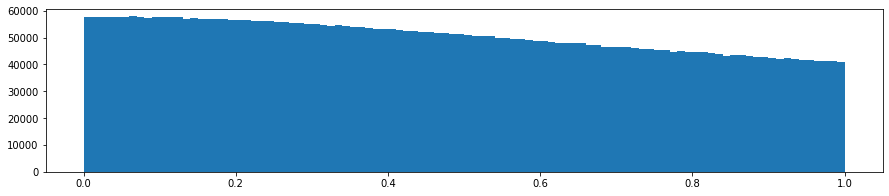

In [49]:
plt.figure(figsize=(15,3))
plt.hist(substat[(substat>0) & (substat<1)], bins = 100)
plt.show()